<a href="https://colab.research.google.com/github/SCTkick/Tecnicas-de-programaci-n/blob/main/Glaciares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

URL DE GITHUB https://github.com/SCTkick/PILOT-TEMP-code/blob/master/Glaciares.ipynb

In [ ]:
!pip install rioxarray
!pip install geopandas
!pip install rasterio
!pip isntall gdal
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 33.2 MB/s eta 0:00:00
ERROR: unknown command "isntall" - maybe you meant "install"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 21.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import pandas as pd
import xarray as xr
import rioxarray as rxr
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd
import re
from osgeo import gdal
import rasterio as rt
from rasterio.plot import show
from rasterio.mask import mask
import numpy as np

### SELECCION DEL AÑO

---



In [ ]:
path="/content/drive/MyDrive/Colab Notebooks/Tecnicas2_tf/2000/Bandas"
os.listdir (path)

['LT05_L2SP_008067_20000212_20200907_02_T1_MTL.txt',
 'LT05_L2SP_008067_20000212_20200907_02_T1_SR_B2.TIF',
 'LT05_L2SP_008067_20000212_20200907_02_T1_SR_B5.TIF']

In [ ]:
glob.glob(path)

['/content/drive/MyDrive/Colab Notebooks/Tecnicas2_tf/2000/Bandas']

In [ ]:
patron= os.path.join(path, '*.txt')
lista = glob.glob(patron)
list_b = sorted (lista, reverse= False)
list_b

['/content/drive/MyDrive/Colab Notebooks/Tecnicas2_tf/2000/Bandas/LT05_L2SP_008067_20000212_20200907_02_T1_MTL.txt']

In [ ]:
metadato_path = list_b[0]

In [ ]:
patron_tiff = os.path.join(path, '*.TIF')
lista = glob.glob(patron_tiff)
list_a = sorted (lista, reverse= False)
list_a

['/content/drive/MyDrive/Colab Notebooks/Tecnicas2_tf/2000/Bandas/LT05_L2SP_008067_20000212_20200907_02_T1_SR_B2.TIF',
 '/content/drive/MyDrive/Colab Notebooks/Tecnicas2_tf/2000/Bandas/LT05_L2SP_008067_20000212_20200907_02_T1_SR_B5.TIF']

### ZONA DE ESTUDIO

In [ ]:
def obtener_cloud_cover(metadata_path):
    with open(metadata_path, 'r') as file:
        metadata_lines = file.readlines()
    for line in metadata_lines:
        if 'CLOUD_COVER ' in line:
            cloud_cover = float(line.split('=')[1].strip())
            return cloud_cover
cloud_cover = obtener_cloud_cover(metadato_path)
print(f"El valor de CLOUD_COVER es: {cloud_cover}%")

El valor de CLOUD_COVER es: 3.0%


Text(0.5, 1.0, 'shapefile')

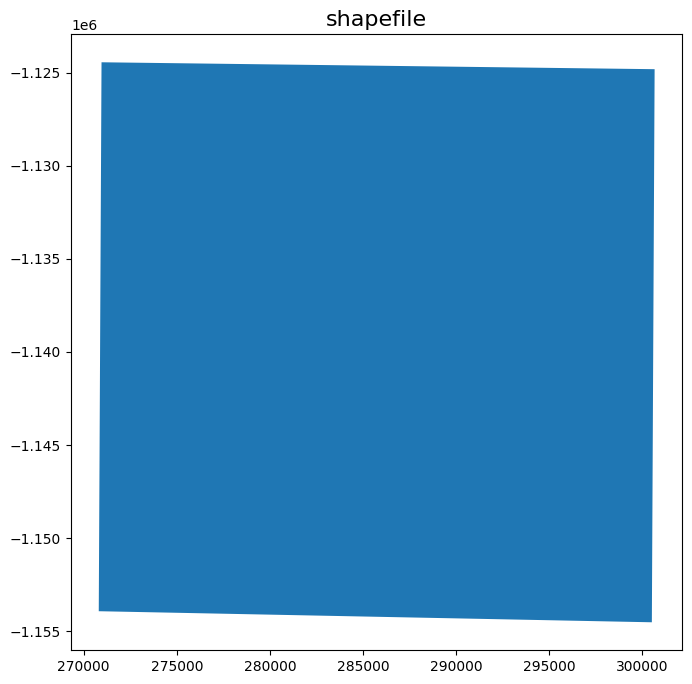

In [ ]:
path_shp="/content/drive/MyDrive/Colab Notebooks/Tecnicas2_tf/Area de estudio/b.shp"
shp=gpd.read_file(path_shp)
fig, ax=plt.subplots(figsize=(8,8))
shp.plot(ax=ax)
ax.set_title("shapefile", fontsize=16)

<Axes: >

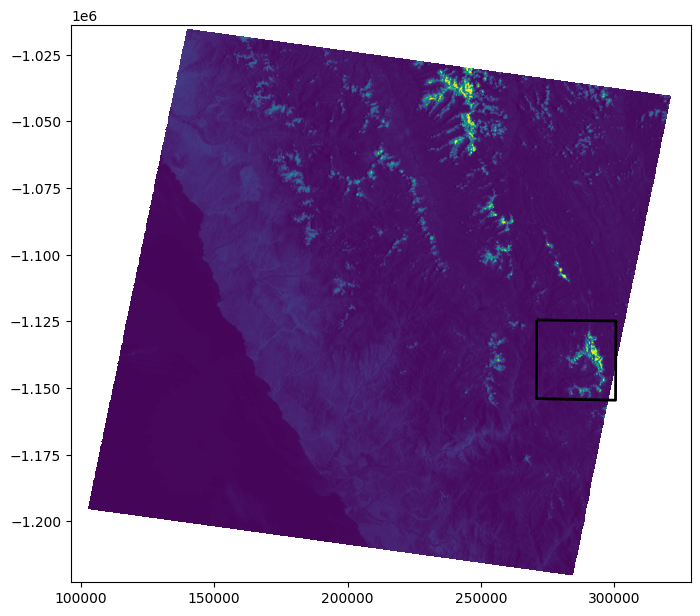

In [ ]:
shp=gpd.read_file(path_shp)
img_rast = rt.open(list_a[0])
fig, ax=plt.subplots(figsize=(8,8))
show(img_rast, ax=ax)
shp.plot(ax=ax,facecolor="None", edgecolor="black", linewidth=2)


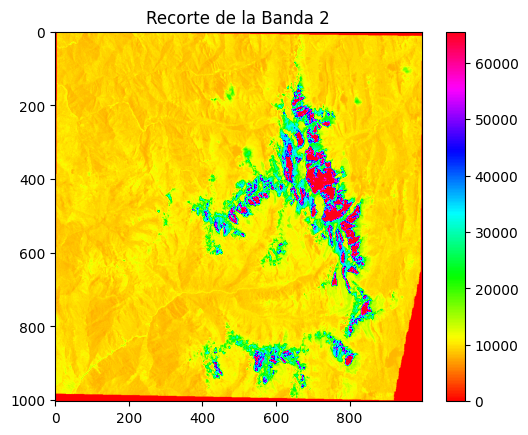

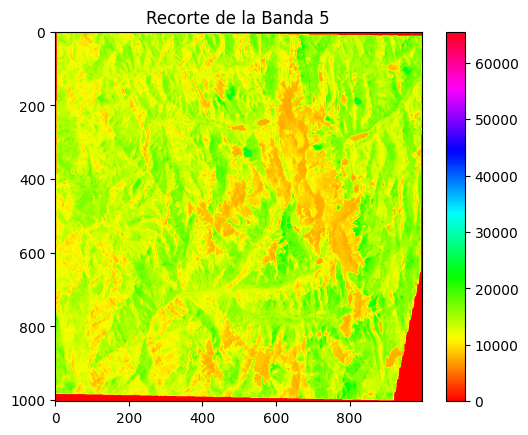

In [ ]:
path_r="/content/drive/MyDrive/Colab Notebooks/Tecnicas2_tf/2000/Recorte"
def recortar(raster_path, shp_path, banda, ruta_guardado):
    gdf = gpd.read_file(shp_path)
    src = rasterio.open(raster_path)
    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    nombre_archivo = f"Banda_{banda}_recortada.TIF"
    ruta_completa = os.path.join(ruta_guardado, nombre_archivo)

    with rasterio.open(
        ruta_completa,
        'w',
        driver='GTiff',
        height=out_image.shape[1],
        width=out_image.shape[2],
        count=1,
        dtype=out_image.dtype,
        crs=src.crs,
        transform=out_transform,
    ) as dest:
        dest.write(out_image)

    plt.imshow(out_image[0, :, :], cmap='hsv')
    plt.title(f"Recorte de la Banda {banda}")
    plt.colorbar()
    plt.show()

recortar(list_a[0], path_shp, 2, path_r)
recortar(list_a[1], path_shp, 5, path_r)



### CORRECCION RADIOMETRICA TOA (Valores digitales a Radiancia)

In [ ]:
patron_r = os.path.join(path_r, '*.TIF')
lista = glob.glob(patron_r)
list_r = sorted (lista, reverse= False)
list_r

['/content/drive/MyDrive/Colab Notebooks/Tecnicas2_tf/2000/Recorte/Banda_2_recortada.TIF',
 '/content/drive/MyDrive/Colab Notebooks/Tecnicas2_tf/2000/Recorte/Banda_5_recortada.TIF']

In [ ]:
def read_img (file):
    return (rxr.open_rasterio (file))
# leyendo cada uno de los path
array_list = [read_img(i) for i in list_r ]

In [ ]:
B2_R=array_list[0]
B5_R=array_list[1]

In [ ]:
def TOA(banda_path, metadato_path,num_banda):
  ganancia, sesgo = obtener_ganancia_sesgo(metadato_path, num_banda)
  matriz_corregida = ganancia * banda_path + sesgo
  return matriz_corregida


def obtener_ganancia_sesgo(metadato_path, banda):
   with open(metadato_path, 'r') as file:
        contenido = file.read()
        match = re.search(fr'REFLECTANCE_MULT_BAND_{banda} = ([^\n]+).*?REFLECTANCE_ADD_BAND_{banda} = ([^\n]+)', contenido, re.DOTALL)
        if match:
            ganancia, sesgo = match.groups()
            ganancia = float(ganancia)
            sesgo = float(sesgo)
            return ganancia, sesgo
B2TOA=TOA(B2_R, metadato_path,"2")
B5TOA=TOA(B5_R, metadato_path,"5")



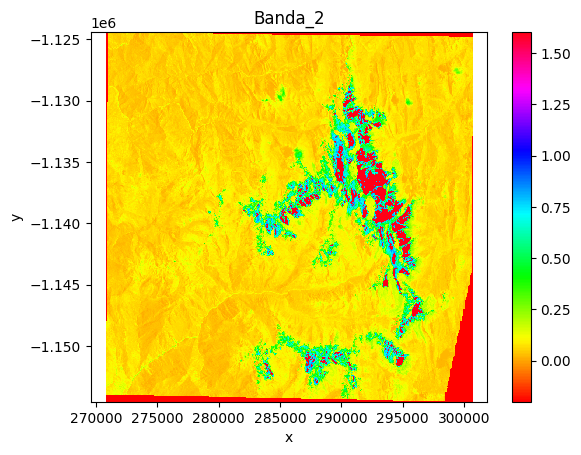

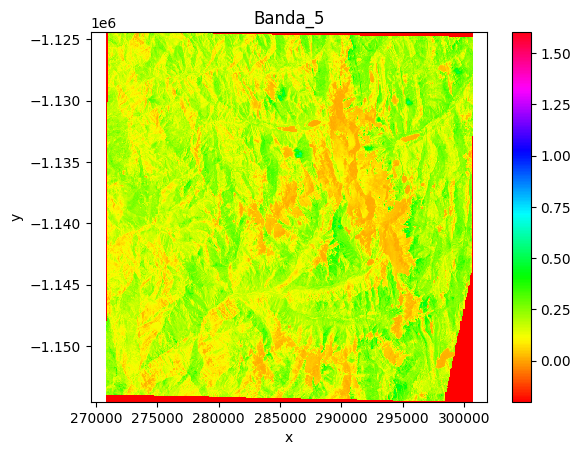

In [ ]:
import dask as dk
def graficar(refl,banda):
  refl_max_b, refl_min_b= dk.compute(
    refl.max(dim=['x', 'y']),
    refl.min(dim=['x', 'y']),
    )
  bot=refl.squeeze()
  plt.figure()
  im_b = bot.compute().plot.imshow(cmap='hsv', vmin=refl_min_b.item(), vmax=refl_max_b.item())
  plt.title(f"Banda_{banda}")
  plt.axis('equal')
  plt.show()
graficar(B2TOA, 2)
graficar(B5TOA, 5)

### CORRECIÓN ATMOSFÉRICA



In [ ]:
def DOS(banda_path, metadato_path,num_banda):
  ganancia, sesgo = obtener_ganancia_sesgo(metadato_path, num_banda)
  matriz_corregida = (banda_path - sesgo) / ganancia
  return matriz_corregida


def obtener_ganancia_sesgo(metadato_path, banda):
   with open(metadato_path, 'r') as file:
        contenido = file.read()
        match = re.search(fr'REFLECTANCE_MULT_BAND_{banda} = ([^\n]+).*?REFLECTANCE_ADD_BAND_{banda} = ([^\n]+)', contenido, re.DOTALL)
        if match:
            ganancia, sesgo = match.groups()
            ganancia = float(ganancia)
            sesgo = float(sesgo)
            return ganancia, sesgo


B2DOS=DOS(B2_R, metadato_path,"2")
B5DOS=DOS(B5_R, metadato_path,"5")



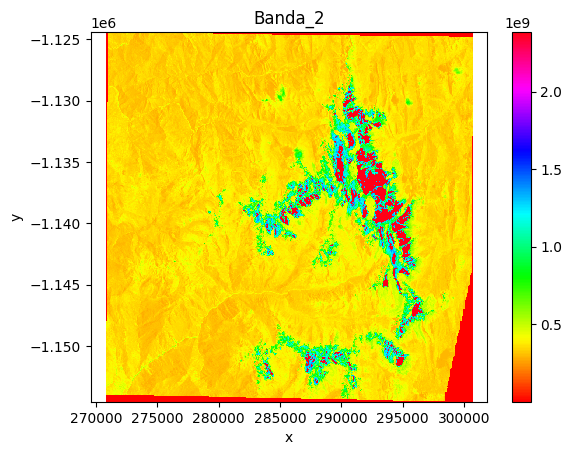

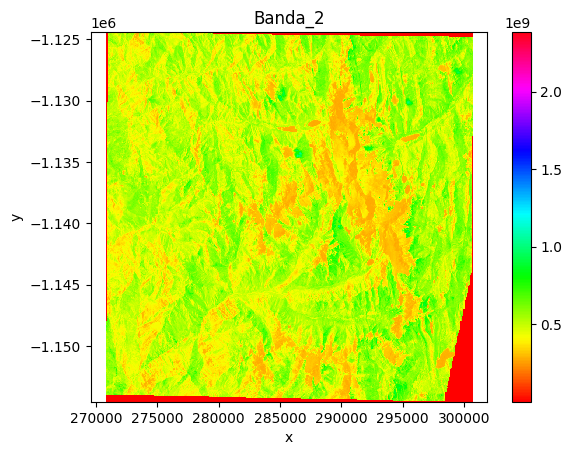

In [ ]:
graficar(B2DOS, 2)
graficar(B5DOS, 2)


### INDICE NDSI

In [ ]:
def ndsi(banda_verde, banda_infrarroja):
  ndsi = (banda_verde - banda_infrarroja) / (banda_verde + banda_infrarroja)
  return ndsi
INDICE_GLACIAR=ndsi(B2DOS,B5DOS)

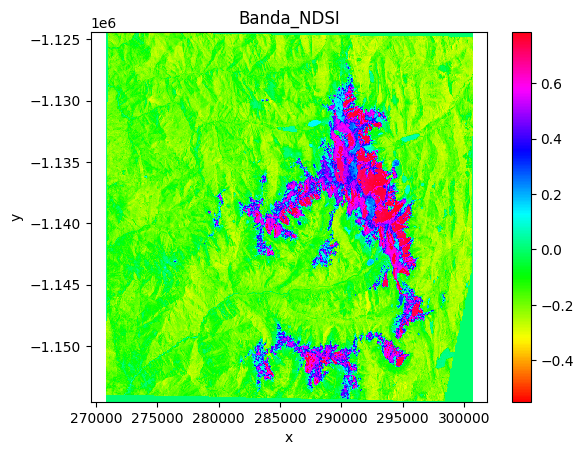

In [ ]:
graficar(INDICE_GLACIAR, "NDSI")
#El indice va de -1 a 1

In [ ]:
INDICE_GLACIAR

<xarray.DataArray (band: 1, y: 1004, x: 996)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.708e+05 2.708e+05 ... 3.006e+05 3.007e+05
  * y            (y) float64 -1.124e+06 -1.124e+06 ... -1.154e+06 -1.155e+06
    spatial_ref  int64 0

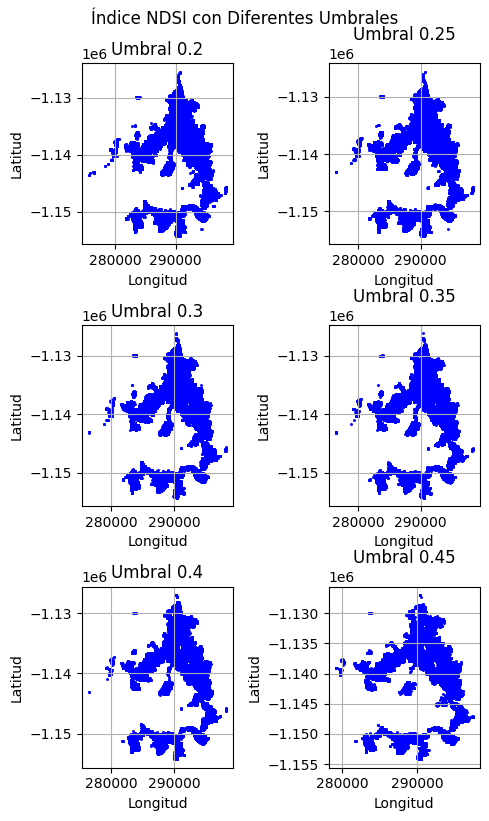

In [ ]:
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
data = INDICE_GLACIAR
umbrales = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
fig, axs = plt.subplots(3, 2, figsize=(5, 8))
x, y = np.meshgrid(data.x[:], data.y[:])

for i, umbral in enumerate(umbrales):
    u = da.where(data[0] > umbral, data[0], 0)
    scatter = axs[i // 2, i % 2].scatter(x[u > 0], y[u > 0], c='blue', marker='.', s=5)
    axs[i // 2, i % 2].set_title(f"Umbral {umbral}")
    axs[i // 2, i % 2].set_xlabel("Longitud")
    axs[i // 2, i % 2].set_ylabel("Latitud")
    axs[i // 2, i % 2].grid(True)

plt.tight_layout()
plt.suptitle("Índice NDSI con Diferentes Umbrales", y=1.02)
plt.show()


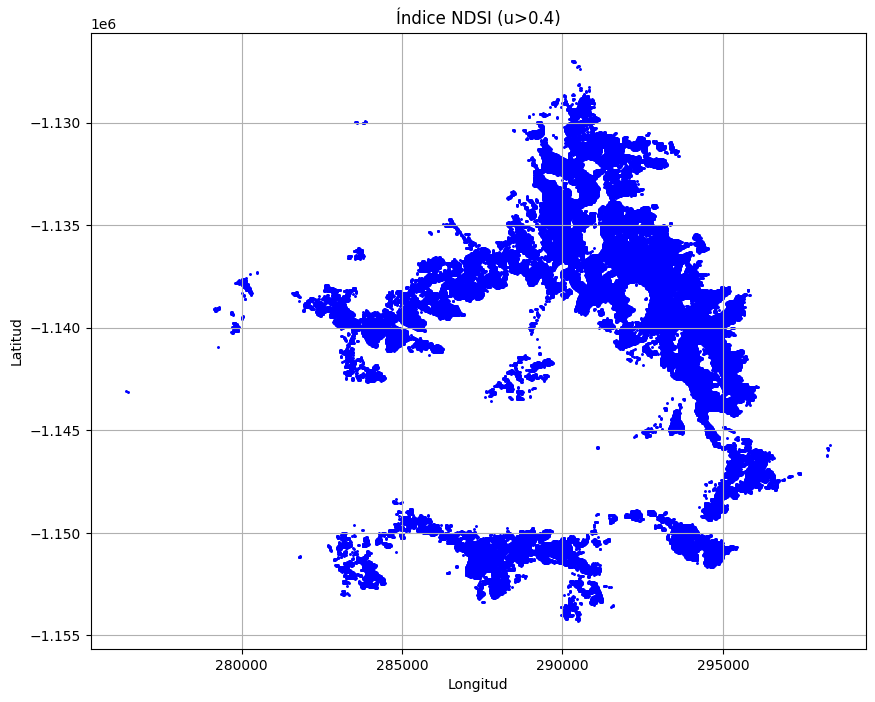

In [ ]:
import dask.array as da

landsat_data = INDICE_GLACIAR
umbral = 0.4
landsat_data_umbral = da.where(landsat_data[0] > umbral, landsat_data[0], 0)

# Crear una malla de coordenadas
x, y = np.meshgrid(landsat_data.x[:], landsat_data.y[:])

# Graficar los píxeles con valor mayor a 0.4
plt.figure(figsize=(10, 8))
plt.scatter(x[landsat_data_umbral > 0], y[landsat_data_umbral > 0], c='blue', marker='.', s=5)
plt.title("Índice NDSI (u>0.4)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.grid(True)
plt.show()


### AREA DEL GLACIAR

In [ ]:
resolucion_metros = 30
area_pixeles = da.count_nonzero(landsat_data_umbral)
area_total_metros_cuadrados = (area_pixeles * resolucion_metros**2)/1000000

print(f"Área ocupada: {area_total_metros_cuadrados.compute()} kilometros cuadrados")


Área ocupada: 65.8746 kilometros cuadrados


Serie de tiempo de pp

In [ ]:
 import pandas as pd
 import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
paht2="/content/drive/MyDrive/UNALM /UNALM-2023-2/TEC-2/TRABAJO FINAL/Tecnicas2_tf/Serie de tiempo/datos de tem, pp.csv"
df=pd.read_csv(paht2,sep=';')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/UNALM /UNALM-2023-2/TEC-2/TRABAJO FINAL/Tecnicas2_tf/Serie de tiempo/datos de tem, pp.csv'

In [ ]:
df

,PARAMETER,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,T2M_MAX,1991,19.72,18.52,18.51,18.97,18.71,19.37,18.81,19.05,19.08,20.67,19.93,20.76
1,T2M_MAX,1992,19.72,21.58,20.19,20.45,19.51,18.23,17.49,18.83,19.48,19.99,20.91,20.37
2,T2M_MAX,1993,18.71,18.88,18.61,17.62,19.34,18.44,17.74,18.18,19.54,18.76,19.30,18.46
3,T2M_MAX,1994,17.60,17.13,18.64,18.21,18.66,17.93,18.45,19.07,20.25,20.33,19.44,20.35
4,T2M_MAX,1995,17.83,20.10,18.36,18.85,18.58,18.18,18.62,19.66,19.19,19.86,19.71,19.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,PRECTOTCORR,2017,5.27,0.00,5.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.27,0.00
89,PRECTOTCORR,2018,0.00,5.27,5.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
90,PRECTOTCORR,2019,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
91,PRECTOTCORR,2020,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pip install altair_viewer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 844.5/844.5 kB 4.1 MB/s eta 0:00:00


##TEMPERATURA MAXIMA

In [ ]:
import pandas as pd
df_acotado2 = df.iloc[0:31, :].copy()
df_acotado2['T2M_MAX'] = df_acotado2.iloc[:, 2:14].mean(axis=1)
df_acotado2.drop(df_acotado2.columns[2:14], axis=1, inplace=True)
df_acotado2.drop(df_acotado2.columns[0], axis=1, inplace=True)
df_acotado2

,YEAR,T2M_MAX
0,1991,19.341667
1,1992,19.729167
2,1993,18.631667
3,1994,18.838333
4,1995,19.033333
5,1996,18.774167
6,1997,19.050000
7,1998,18.968333
8,1999,18.258333
9,2000,18.415000


In [ ]:
YEAR=df_acotado2['YEAR']
T2M_MAX = df_acotado2['T2M_MAX']
# Conteo de valores nulos
print("Habra algun calor null: ", df_acotado2.isnull().values.any())

# Si existen nulos eliminar filas
if df_acotado2.isnull().values.any():
    df_acotado2.dropna()
else:
    print("No hacer nada!!!")

Muestreo = pd.DataFrame(df_acotado2)

Habra algun calor null:  False
No hacer nada!!!


In [ ]:
# concatenando
Muestreo = pd.concat([YEAR,T2M_MAX], axis= 1, ignore_index=True)
# nombre de columnas
Muestreo.columns = ["YEAR","TT2M_MAX"]
#
Muestreo.head

<bound method NDFrame.head of     YEAR   TT2M_MAX
0   1991  19.341667
1   1992  19.729167
2   1993  18.631667
3   1994  18.838333
4   1995  19.033333
5   1996  18.774167
6   1997  19.050000
7   1998  18.968333
8   1999  18.258333
9   2000  18.415000
10  2001  18.683333
11  2002  19.210833
12  2003  19.715833
13  2004  19.375833
14  2005  19.548333
15  2006  19.358333
16  2007  19.161667
17  2008  19.091667
18  2009  19.460000
19  2010  20.044167
20  2011  19.427500
21  2012  19.460000
22  2013  19.097500
23  2014  18.824167
24  2015  18.882500
25  2016  19.154167
26  2017  18.191667
27  2018  17.857500
28  2019  19.596667
29  2020  19.690000
30  2021  19.446667>

In [ ]:
df_muestreo=pd.DataFrame(Muestreo)
df_muestreo

,YEAR,TT2M_MAX
0,1991,19.341667
1,1992,19.729167
2,1993,18.631667
3,1994,18.838333
4,1995,19.033333
5,1996,18.774167
6,1997,19.050000
7,1998,18.968333
8,1999,18.258333
9,2000,18.415000


In [ ]:
# Convertir la columna 'YEAR' a tipo de dato datetime
df_acotado2['YEAR'] = pd.to_datetime(df_acotado2['YEAR'], format='%Y')

# Crear gráfico con Altair
base = alt.Chart(df_acotado2).encode(
    x='YEAR:T',
    y=alt.Y('T2M_MAX:Q', title='T2M_MAX', scale=alt.Scale(domain=[16, 22])),
    color=alt.Color('T2M_MAX:Q', scale=alt.Scale(scheme='viridis')),
    tooltip=[
        alt.Tooltip('YEAR:T', title='YEAR'),
        alt.Tooltip('T2M_MAX:Q', title='T2M_MAX')]
).properties(width=1000, height=250)

# Puntos
points = base.mark_point(size=50)

# Tendencia
tendencia = base.transform_regression('YEAR', 'T2M_MAX').mark_line(color='red', size=1.2)

# Filtrar el rango deseado en el eje y
filtered_chart = (points + tendencia).transform_filter(
    (alt.datum['T2M_MAX'] >= 16) & (alt.datum['T2M_MAX'] <= 22)
)

# Mostrar el gráfico
filtered_chart


alt.LayerChart(...)

In [ ]:
df_acotado2['YEAR'] = pd.to_datetime(df_acotado2['YEAR'], format='%Y')
# Plot de la TEM PROMEDIO
line=alt.Chart(df_acotado2).mark_line(size=1.5).encode(
  x = 'YEAR:T',
  y = 'T2M_MAX:Q',
  tooltip = [
    alt.Tooltip('YEAR:T', title='YEAR'),
    alt.Tooltip("T2M_MAX:Q", title='T2M_MAX')])\
      .properties(width=1000, height=250)
##-------------------------------------------------------------------------------

tendecia = line.transform_regression('YEAR','T2M_MAX')\
           .mark_line(color='red',size=1.2)

points = alt.Chart(df_acotado2).mark_point(size=3.8).encode(
    x='YEAR:T',
    y=alt.Y('T2M_MAX:Q',axis=alt.Axis(title='T2M_MAX') ),
    tooltip = [
         alt.Tooltip('YEAR:T', title='YEAR'),
         alt.Tooltip('T2M_MAX:Q', title='T2M_MAX')] )
# Uniendo
line + points + tendecia
#-------------------------------------------------------------------------------

alt.LayerChart(...)

#TEMPERATURA MIN

In [ ]:
import pandas as pd
df_acotado1 = df.iloc[31:64, :].copy()
df_acotado1['T2M_MIN'] = df_acotado1.iloc[:, 2:14].mean(axis=1)
df_acotado1.drop(df_acotado1.columns[2:14], axis=1, inplace=True)
df_acotado1.drop(df_acotado1.columns[0], axis=1, inplace=True)
df_acotado1

,YEAR,T2M_MIN
31,1991,-0.120833
32,1992,0.020000
33,1993,0.041667
34,1994,0.569167
35,1995,0.036667
36,1996,0.209167
37,1997,0.440833
38,1998,0.632500
39,1999,-0.153333
40,2000,-0.694167


In [ ]:
YEAR=df_acotado1['YEAR']
T2M_MIN = df_acotado1['T2M_MIN']
# Conteo de valores nulos
print("Habra algun calor null: ", df_acotado1.isnull().values.any())

# Si existen nulos eliminar filas
if df_acotado1.isnull().values.any():
    df_acotado1.dropna()
else:
    print("No hacer nada!!!")

Muestreo2 = pd.DataFrame(df_acotado1)

Habra algun calor null:  False
No hacer nada!!!


In [ ]:
# Convertir la columna 'YEAR' a tipo de dato datetime
df_acotado1['YEAR'] = pd.to_datetime(df_acotado1['YEAR'], format='%Y')

# Crear gráfico con Altair
base = alt.Chart(df_acotado1).encode(
    x='YEAR:T',
    y=alt.Y('T2M_MIN:Q', title='T2M_MIN', scale=alt.Scale(domain=[-3, 3])),
    color=alt.Color('T2M_MIN:Q', scale=alt.Scale(scheme='viridis')),
    tooltip=[
        alt.Tooltip('YEAR:T', title='YEAR'),
        alt.Tooltip('T2M_MIN:Q', title='T2M_MIN')]
).properties(width=1000, height=250)

# Puntos
points = base.mark_point(size=50)

# Tendencia
tendencia = base.transform_regression('YEAR', 'T2M_MIN').mark_line(color='red', size=1.2)

# Filtrar el rango deseado en el eje y
filtered_chart = (points + tendencia).transform_filter(
    (alt.datum['T2M_MIN'] >= -3) & (alt.datum['T2M_MIN'] <= 3)
)

# Mostrar el gráfico
filtered_chart

alt.LayerChart(...)

In [ ]:
df_acotado1['YEAR'] = pd.to_datetime(df_acotado1['YEAR'], format='%Y')
# Plot de la Temp min
line=alt.Chart(df_acotado1).mark_line(size=1.5).encode(
  x = 'YEAR:T',
  y = 'T2M_MIN:Q',
  tooltip = [
    alt.Tooltip('YEAR:T', title='YEAR'),
    alt.Tooltip("T2M_MIN:Q", title='T2M_MIN')])\
      .properties(width=1000, height=250)
##-------------------------------------------------------------------------------

tendecia = line.transform_regression('YEAR','T2M_MIN')\
           .mark_line(color='red',size=1.2)

points = alt.Chart(df_acotado1).mark_point(size=3.8).encode(
    x='YEAR:T',
    y=alt.Y('T2M_MIN:Q',axis=alt.Axis(title='T2M_MIN') ),
    tooltip = [
         alt.Tooltip('YEAR:T', title='YEAR'),
         alt.Tooltip('T2M_MIN:Q', title='T2M_MIN')] )
# Uniendo
line + points + tendecia
#-------------------------------------------------------------------------------

alt.LayerChart(...)

#PRECIPITACION

In [ ]:
import pandas as pd
df_acotado3 = df.iloc[62:94, :].copy()
df_acotado3['PRECTOTCORR'] = df_acotado3.iloc[:, 2:14].sum(axis=1)
df_acotado3.drop(df_acotado3.columns[2:14], axis=1, inplace=True)
df_acotado3.drop(df_acotado3.columns[0], axis=1, inplace=True)
df_acotado3

,YEAR,PRECTOTCORR
62,1991,0.00
63,1992,0.00
64,1993,0.00
65,1994,0.00
66,1995,0.00
67,1996,0.00
68,1997,0.00
69,1998,10.54
70,1999,5.27
71,2000,10.54


In [ ]:
YEAR=df_acotado3['YEAR']
PRECIPITACION= df_acotado3['PRECTOTCORR']
# Conteo de valores nulos
print("Habra algun calor null: ", df_acotado3.isnull().values.any())

# Si existen nulos eliminar filas
if df_acotado3.isnull().values.any():
    df_acotado3.dropna()
else:
    print("No hacer nada!!!")

Muestreo2 = pd.DataFrame(df_acotado3)

Habra algun calor null:  False
No hacer nada!!!


In [ ]:
# concatenando
Muestreo3 = pd.concat([YEAR,PRECIPITACION], axis= 1, ignore_index=True)
# nombre de columnas
Muestreo3.columns = ["YEAR","PRECIPITACION"]
#
Muestreo3.head

<bound method NDFrame.head of     YEAR  PRECIPITACION
62  1991           0.00
63  1992           0.00
64  1993           0.00
65  1994           0.00
66  1995           0.00
67  1996           0.00
68  1997           0.00
69  1998          10.54
70  1999           5.27
71  2000          10.54
72  2001           0.00
73  2002           0.00
74  2003           0.00
75  2004           0.00
76  2005           0.00
77  2006           0.00
78  2007           0.00
79  2008           0.00
80  2009           0.00
81  2010           0.00
82  2011           0.00
83  2012           0.00
84  2013           0.00
85  2014           0.00
86  2015           0.00
87  2016          21.08
88  2017          15.81
89  2018          10.54
90  2019           0.00
91  2020           0.00
92  2021           6.55>

In [ ]:
df_muestreo3=pd.DataFrame(Muestreo3)
df_muestreo3

,YEAR,PRECIPITACION
62,1991,0.00
63,1992,0.00
64,1993,0.00
65,1994,0.00
66,1995,0.00
67,1996,0.00
68,1997,0.00
69,1998,10.54
70,1999,5.27
71,2000,10.54


In [ ]:
# Convertir la columna 'YEAR' a tipo de dato datetime
df_muestreo3['YEAR'] = pd.to_datetime(df_muestreo3['YEAR'], format='%Y')

# Crear gráfico con Altair
base = alt.Chart(df_muestreo3).encode(
    x='YEAR:T',
    y=alt.Y('PRECIPITACION:Q', title='PRECIPITACION', scale=alt.Scale(domain=[2, 25])),
    color=alt.Color('PRECIPITACION:Q', scale=alt.Scale(scheme='viridis')),
    tooltip=[
        alt.Tooltip('YEAR:T', title='YEAR'),
        alt.Tooltip('PRECIPITACION:Q', title='PRECIPITACION')]
).properties(width=1000, height=250)

# Puntos
points = base.mark_point(size=50)

# Tendencia
tendencia = base.transform_regression('YEAR', 'PRECIPITACION').mark_line(color='red', size=1.2)
# Filtrar el rango deseado en el eje y
filtered_chart = (points + tendencia).transform_filter(
    (alt.datum['PRECIPITACION'] >= 2) & (alt.datum['PRECIPITACION'] <= 25)
)


# Mostrar el gráfico
filtered_chart

alt.LayerChart(...)

In [ ]:
df_muestreo3['YEAR'] = pd.to_datetime(df_muestreo3['YEAR'], format='%Y')
# Plot de la PP
line=alt.Chart(df_muestreo3).mark_line(size=1.5).encode(
  x = 'YEAR:T',
  y = 'PRECIPITACION:Q',
  tooltip = [
    alt.Tooltip('YEAR:T', title='YEAR'),
    alt.Tooltip("PRECIPITACION:Q", title='PRECIPITACION')])\
      .properties(width=1000, height=250)
##-------------------------------------------------------------------------------

tendecia = line.transform_regression('YEAR','PRECIPITACION')\
           .mark_line(color='red',size=1.2)

points = alt.Chart(df_muestreo3).mark_point(size=3.8).encode(
    x='YEAR:T',
    y=alt.Y('PRECIPITACION:Q',axis=alt.Axis(title='PRECIPITACION') ),
    tooltip = [
         alt.Tooltip('YEAR:T', title='YEAR'),
         alt.Tooltip('PRECIPITACION:Q', title='PRECIPITACION')] )
# Uniendo
line + points + tendecia
#-------------------------------------------------------------------------------

alt.LayerChart(...)